In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import scipy.stats as stats

from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
newsfile = pd.read_csv('abcnews-date-text.csv', parse_dates = [0], infer_datetime_format = True)

In [3]:
newsfile2 = newsfile['headline_text']
newsfile2.index = newsfile['publish_date'] #This is to publish the dates of the dataset in a way that can be parsed properly for further analysis like timeseries

newsfile2.sample(10) #Random sample of the dataset (10)

publish_date
2013-09-10                                      dry mallee soil
2011-02-04                             plucky kings sting 36ers
2019-10-01    china marked the 70 years of communist party rule
2004-06-14    patient diversion highlights system meltdown libs
2007-02-22            goodwin to lead crows in pre season match
2011-01-27              boarded up homeswest homes under repair
2015-12-14    australias most expensive irrigation scheme op...
2014-02-19                                southern seed success
2017-07-07    cinematographer david brill shares insights fr...
2003-06-02                n korea says reprocessing nearly done
Name: headline_text, dtype: object

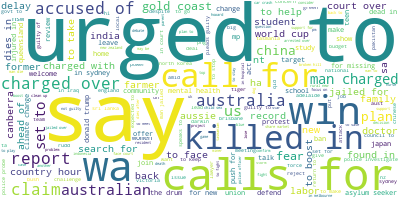

In [4]:
#Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(newsfile['headline_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [43]:
# Defining the helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vec_headlines = count_vectorizer.fit_transform(text_data.values)
    vec_total = np.sum(vec_headlines, axis=0)
    word_indices = np.flip(np.argsort(vec_total)[0,:], 1)
    word_values = np.flip(np.sort(vec_total)[0,:],1)
    
    word_vec = np.zeros((n_top_words, vec_headlines.shape[1]))
    for i in range(n_top_words):
        word_vec[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vec)]

    return (words, word_values[0,:n_top_words].tolist()[0])

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=newsfile2)

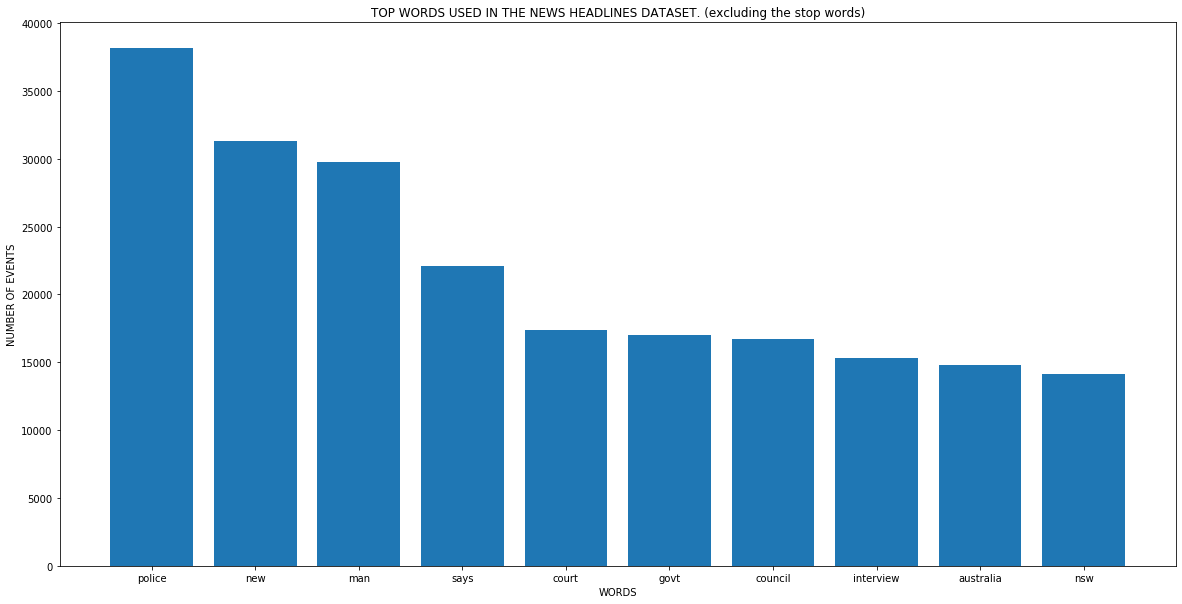

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title('TOP WORDS USED IN THE NEWS HEADLINES DATASET. (excluding the stop words)');
ax.set_xlabel('WORDS');
ax.set_ylabel('NUMBER OF EVENTS');
plt.show()

In [7]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = newsfile2.sample(n=10000, random_state=0).values

print('HEADLINE BEFORE VECTORIZATION: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('HEADLINE AFTER VECTORIZATION: \n{}'.format(small_document_term_matrix[123]))

HEADLINE BEFORE VECTORIZATION: mount isa kids urged to have lead level checks
HEADLINE AFTER VECTORIZATION: 
  (0, 2236)	1
  (0, 6532)	1
  (0, 11884)	1
  (0, 5933)	1
  (0, 7422)	1
  (0, 6218)	1
  (0, 6449)	1


In [8]:
num_topics = 10

In [9]:
lsa_model = TruncatedSVD(n_components=num_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [10]:
def get_lsa_topics(lda_model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = lsa_model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [11]:
get_lsa_topics(lsa_model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,police,new,man,says,council,govt,nsw,crash,court,crash
1,man,says,charged,council,govt,nsw,coast,qld,death,car
2,new,council,court,govt,nsw,qld,death,court,interview,govt
3,charged,govt,new,nsw,plan,urged,north,car,accused,nsw
4,car,zealand,murder,water,qld,death,crash,woman,nsw,woman
5,court,laws,accused,plan,water,south,gold,charged,told,driver
6,murder,health,death,qld,coast,wa,south,driver,govt,fatal
7,crash,australia,sydney,health,court,crash,australia,australia,face,charged
8,nsw,qld,says,wa,health,australia,election,death,murder,council
9,qld,deal,dies,mp,urged,north,win,cup,faces,death


In [12]:
# Defining the helper functions
def get_keys(topic_matrix):
    '''
    This returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    This returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [13]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [14]:
# Defining the helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    This returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(num_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [15]:
top_n_words_lsa = get_top_n_words(15, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  police search missing attack assault investigate man house probe release claims officer body car drug
Topic 2:  new deal laws mayor service campaign zealand coach anti chief war announces season set fiji
Topic 3:  man murder charged hospital guilty accused arrested jailed child bail darwin years sex court stabbing
Topic 4:  says business mp minister labor pm state union big trump industry iraq work key health
Topic 5:  council plan water calls health funding plans centre indigenous help community group national power rural
Topic 6:  govt urged talks wa nt gets drought sale flu victims vic push claims act government
Topic 7:  nsw win coast north election south gold school country queensland abc weather rain korea west
Topic 8:  australian qld crash australia sydney day woman cup market world home china dies car wins
Topic 9:  interview court death face accused told michael alleged faces inquest rape extended trial david hears
Topic 10:  truck fatal train drivers car boundary c

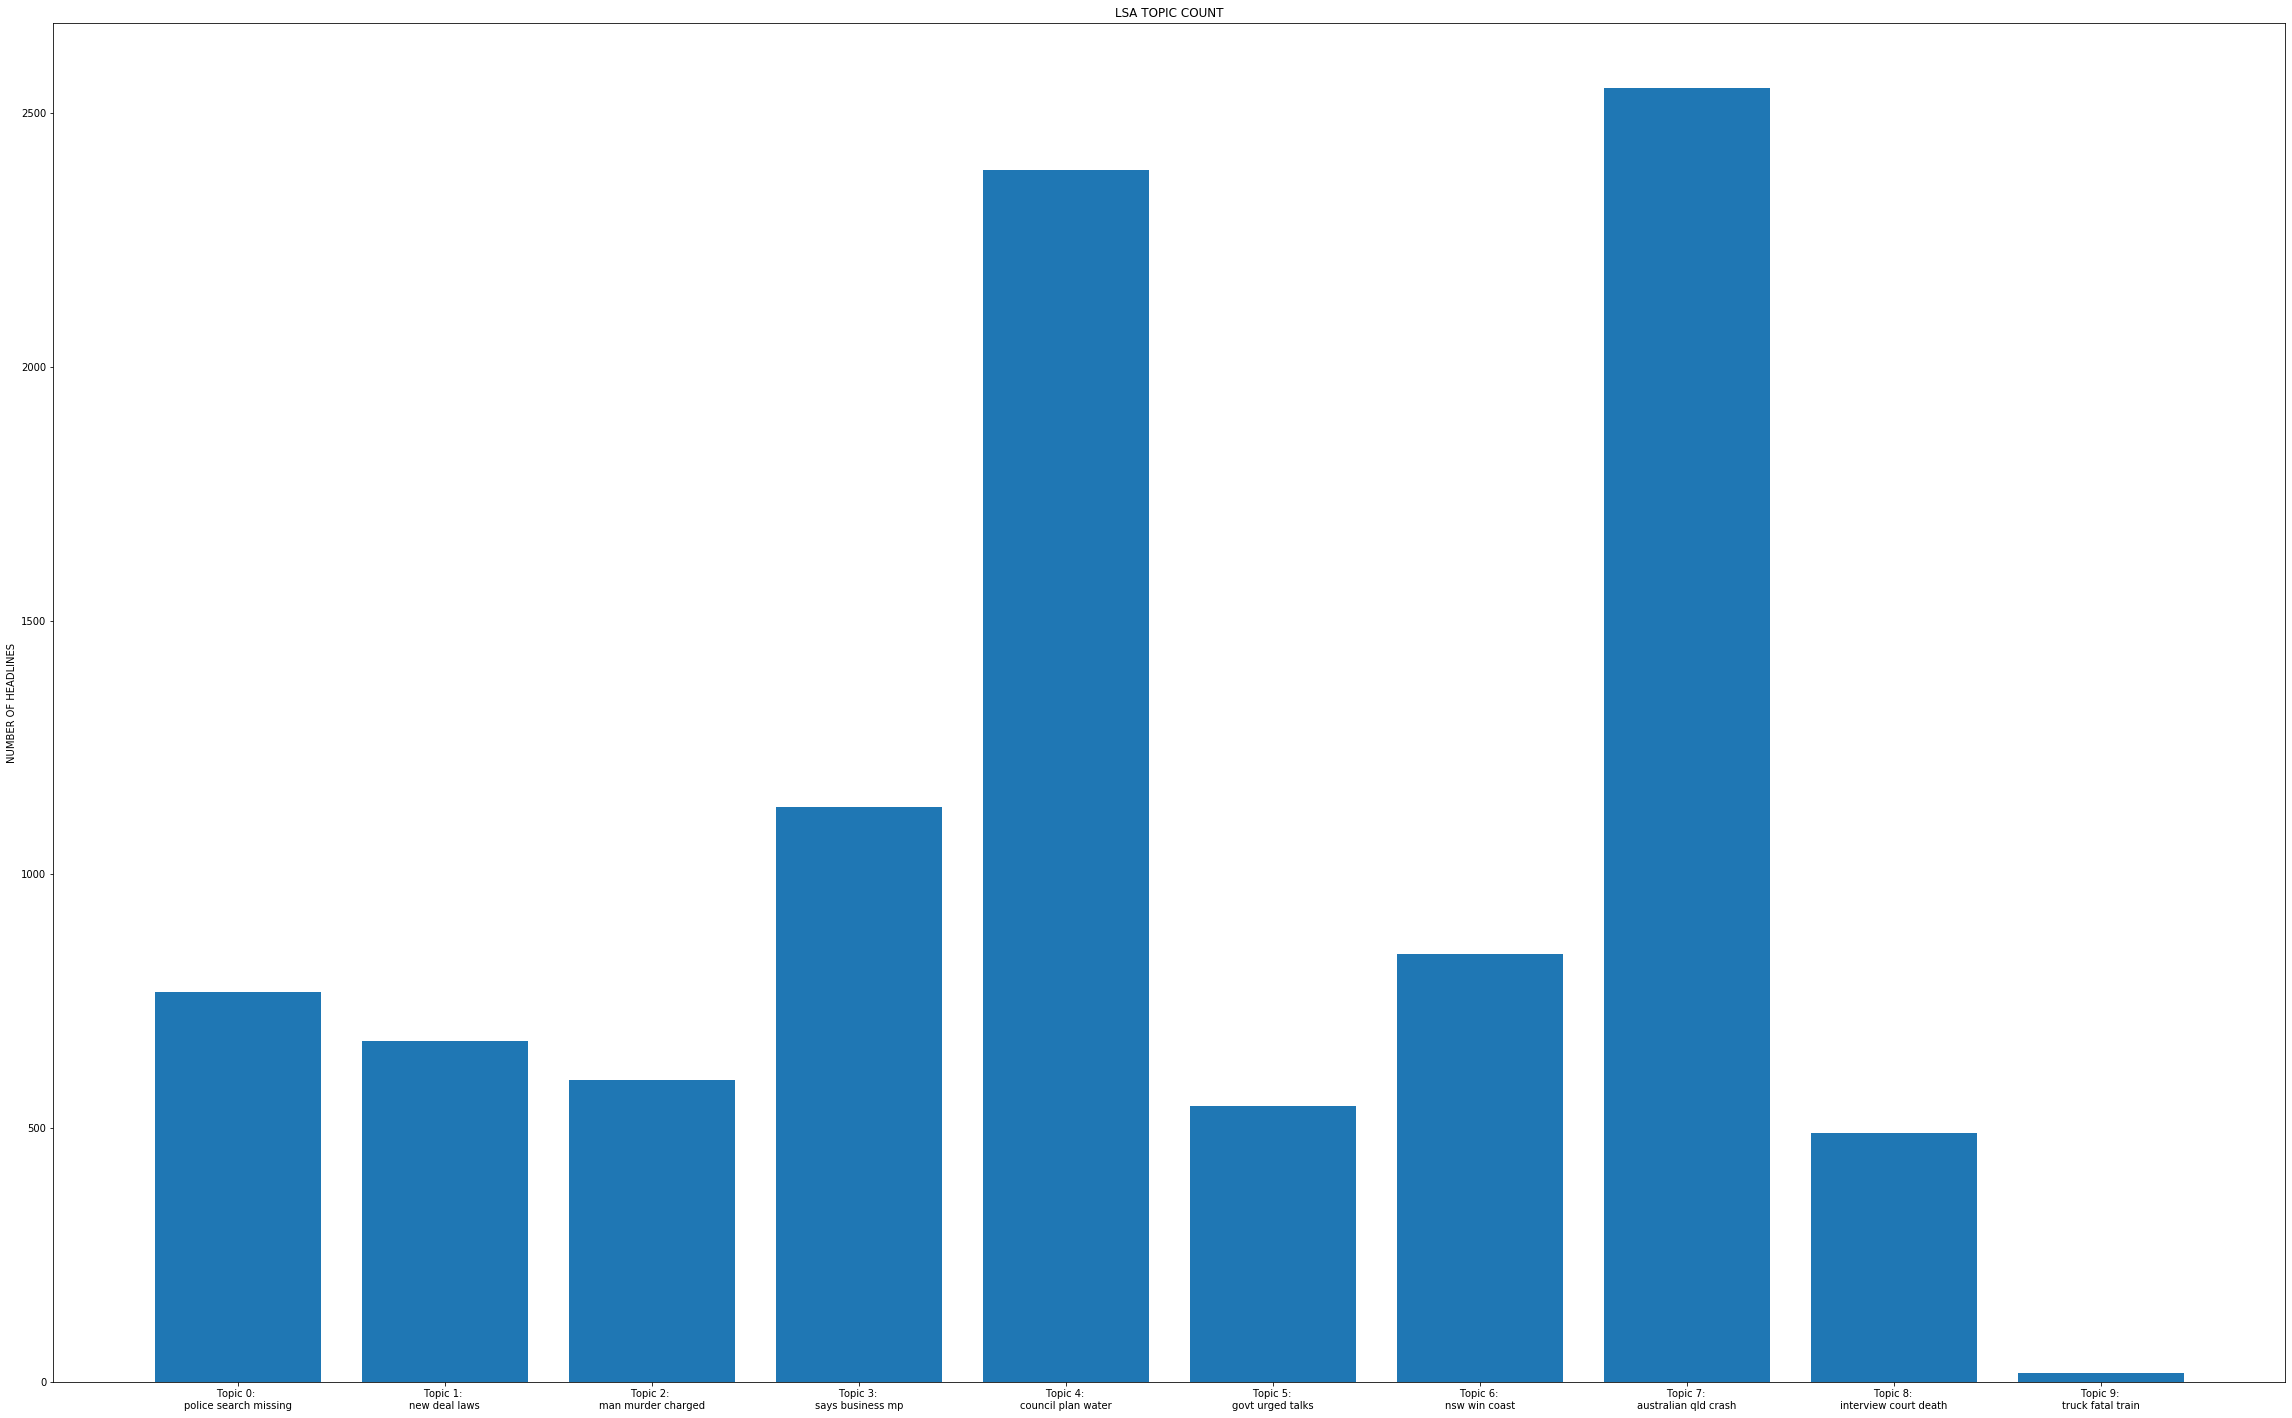

In [16]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(40,25))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('NUMBER OF HEADLINES');
ax.set_title('LSA TOPIC COUNT');
plt.show()

In [17]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.047s...
[t-SNE] Computed neighbors for 10000 samples in 4.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.003508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.657532
[t-SNE] KL divergence after 2000 iterations: 1.245369


In [18]:
# Defining the helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    This returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(num_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [19]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:num_topics]

In [20]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LSA TOPICS".format(num_topics), plot_width=900, plot_height=1000)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(num_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [21]:
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [22]:
def get_lda_topics(lda_model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = lda_model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [23]:
get_lda_topics(lda_model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,council,nsw,new,qld,police,crash,interview,man,court,govt
1,death,charged,car,australia,market,coast,school,win,australian,says
2,sydney,report,year,south,cup,home,election,day,water,plan
3,woman,urged,attack,deal,sa,north,nt,guilty,accused,boost
4,trial,calls,plans,pm,hit,gold,indigenous,work,hospital,fight
5,claims,world,health,farmers,talks,group,country,mp,wa,help
6,labor,government,minister,rise,melbourne,case,public,final,test,killed
7,dies,search,big,family,drug,injured,brisbane,gets,open,power
8,sex,wins,abc,road,china,charges,laws,push,face,action
9,queensland,funding,house,weather,west,funds,missing,assault,national,adelaide


In [24]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [25]:
top_n_words_lda = get_top_n_words(15, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  council death sydney woman wa trial labor murder sex claims child changes queensland record victims
Topic 2:  nsw report search calls urged centre government funding change climate world continues dead charged wins
Topic 3:  new year house abc business health car big minister plans state attack housing high lead
Topic 4:  qld australia south deal rise pm police farmers road weather pay new says western family
Topic 5:  police market talks melbourne sa drug cup china flu new west fears war hits gas
Topic 6:  coast crash gold north home injured police group charges funds case residents man safety land
Topic 7:  interview election school nt indigenous missing public brisbane darwin cyclone nrl country laws season threat
Topic 8:  man win guilty day police arrested union final pleads mp murder work assault says gets
Topic 9:  court water australian accused hospital open man face test says bail canberra wa national driver
Topic 10:  govt says plan power rural boost health action h

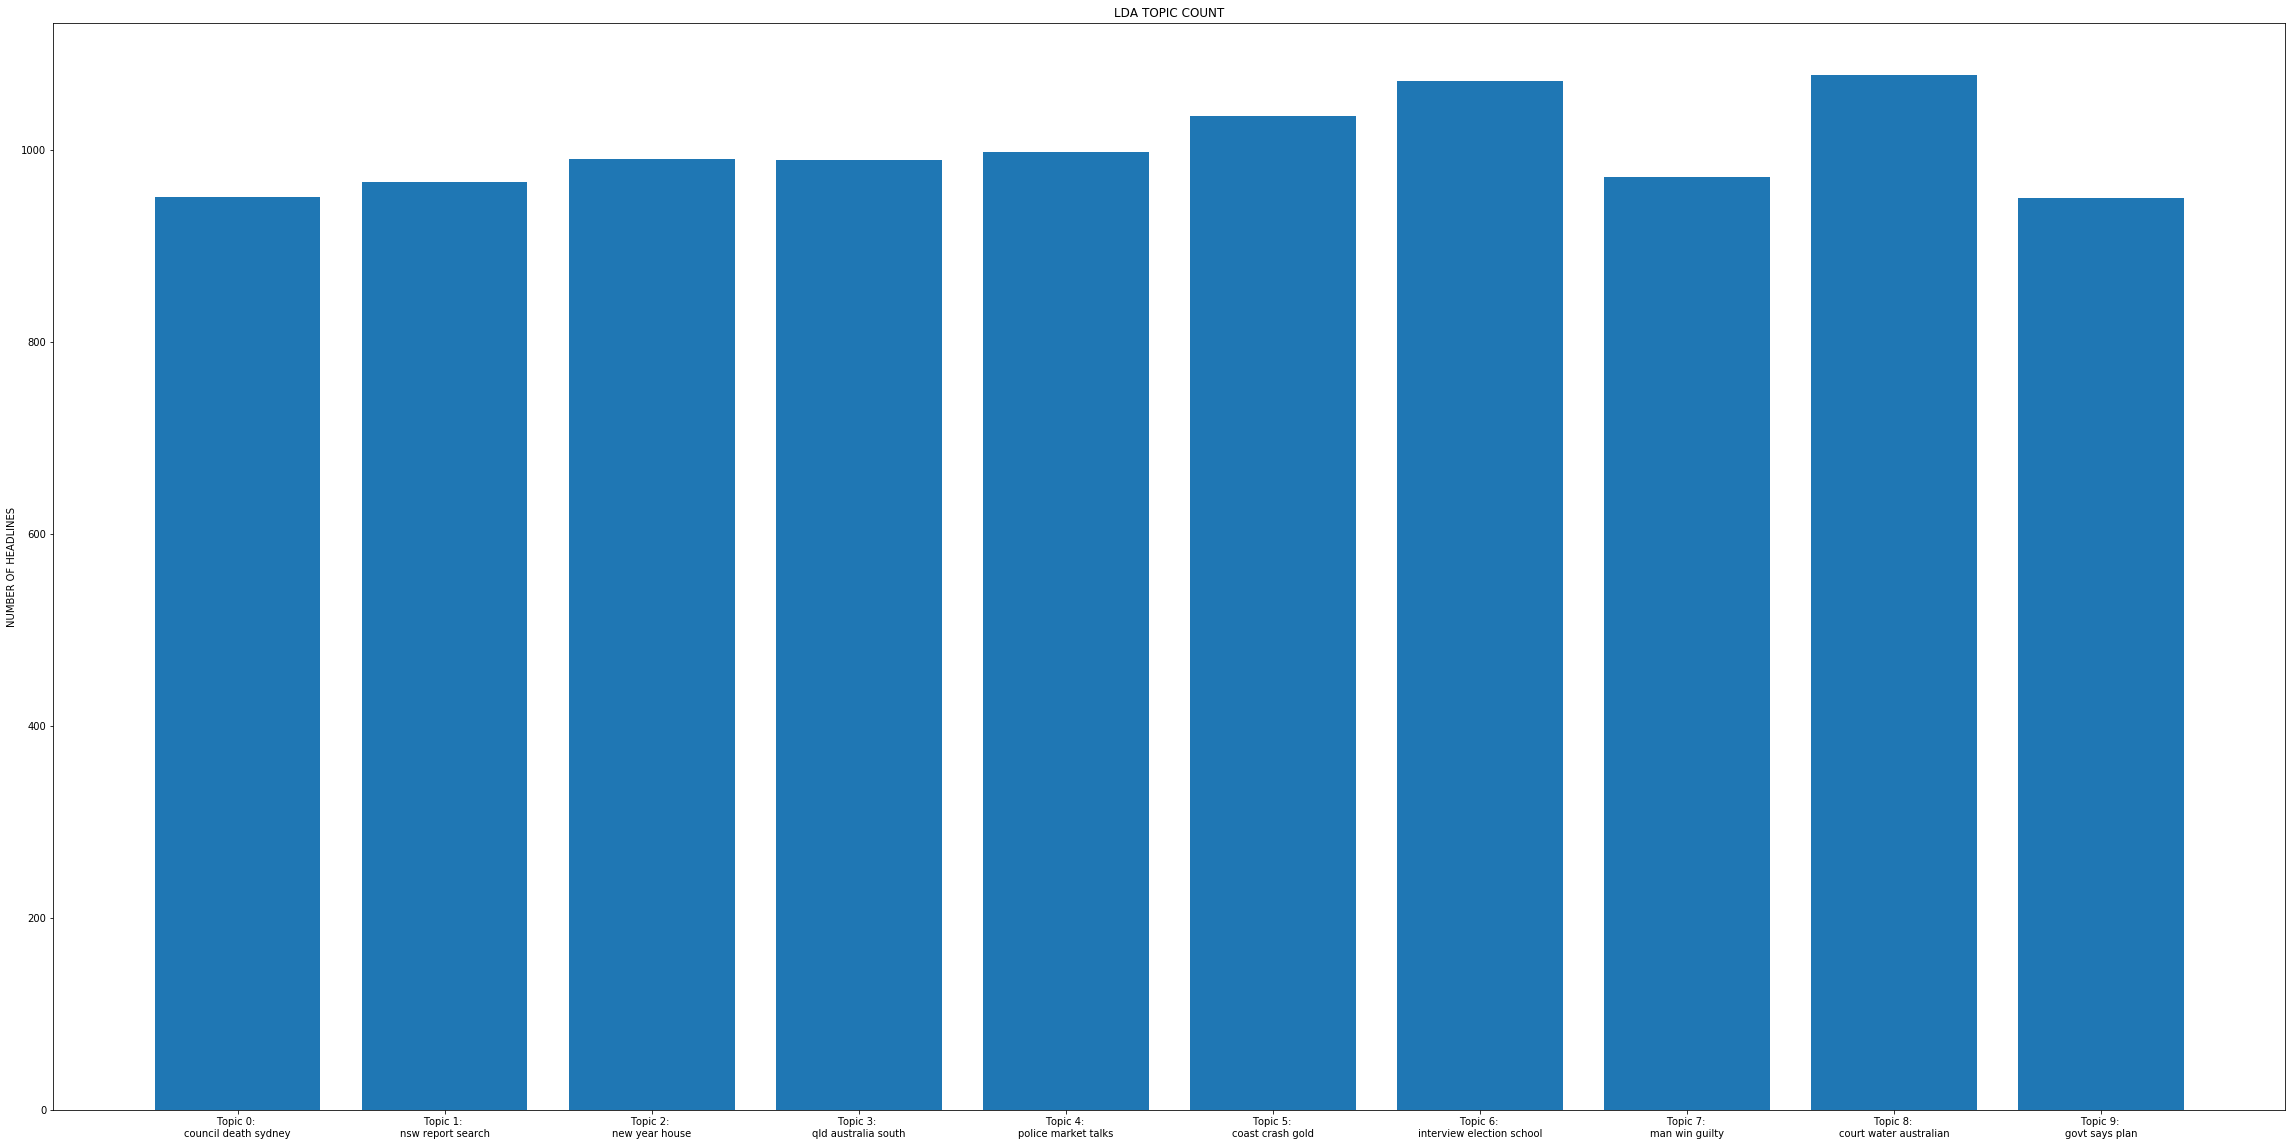

In [26]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA TOPIC COUNT');
ax.set_ylabel('NUMBER OF HEADLINES');

In [27]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.052s...
[t-SNE] Computed neighbors for 10000 samples in 5.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.479576
[t-SNE] KL divergence after 2000 iterations: 1.566560


In [28]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LDA TOPICS".format(num_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(num_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

In [30]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(small_document_term_matrix);

In [31]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [32]:
#obtain a NMF model.
model = NMF(n_components=num_topics, init='nndsvd');
#fit the model
nnf_topic_matrix = model.fit_transform(xtfidf_norm)
nnf_topic_matrix

array([[0.00000000e+00, 0.00000000e+00, 7.85068469e-05, ...,
        3.27767523e-03, 0.00000000e+00, 1.33408047e-03],
       [0.00000000e+00, 0.00000000e+00, 6.51768358e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.28459160e-04, 0.00000000e+00, 8.50384959e-05, ...,
        2.19185568e-03, 2.57354219e-03, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.52869032e-06, 2.13639254e-05, ...,
        2.86678038e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.12501851e-04, ...,
        2.36585212e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.43801406e-04, ...,
        5.00966047e-03, 0.00000000e+00, 0.00000000e+00]])

In [33]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [34]:
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,abc,interview,police,man,new,market,crash,council,group,closer
1,weather,michael,investigate,charged,laws,news,woman,water,islington,pm
2,entertainment,andrew,search,court,zealand,business,fatal,govt,tourism,pm1
3,business,clarke,probe,murder,deal,rural,killed,plan,robbery,am1
4,sport,john,open,accused,intervention,national,car,nsw,plans,news
5,news,extended,car,death,announces,analysis,dies,says,backs,announces
6,analysis,mark,assault,hospital,year,australian,driver,qld,green,takes
7,wild,david,missing,sydney,face,share,dead,health,claims,step
8,friday,chris,officer,bail,centre,wrap,injured,urged,happy,australian
9,monday,sam,drug,stabbing,chief,expansion,road,election,community,rise


In [35]:
nnf_keys = get_keys(nnf_topic_matrix)
nnf_categories, nnf_counts = keys_to_counts(nnf_keys)

In [36]:
top_n_words_nnf = get_top_n_words(15, nnf_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_nnf)):
    print("Topic {}: ".format(i+1), top_n_words_nnf[i])

Topic 1:  abc weather sport wild entertainment news contact friday north monday warning business victoria speaks golden
Topic 2:  interview michael david smith nrl john clarke extended mark media andrew sam moore speaks mcgrath
Topic 3:  police search open investigate drug probe officer body release clash car suspicious protesters crime seized
Topic 4:  man court death charged murder sydney accused hospital guilty face missing brisbane arrested charges assault
Topic 5:  new year laws deal announces zealand coach chief campaign season police war york unions home
Topic 6:  market australian rural business national news share lead mining nrn closes week analysis grain gains
Topic 7:  crash woman car dies killed dead injured road driver fatal train iraq perth kills children
Topic 8:  says council govt nsw plan qld australia water wa health win urged calls coast election
Topic 9:  group claims violence lose rights keen green domestic tourism happy robbery changes economic doctors title
Topi

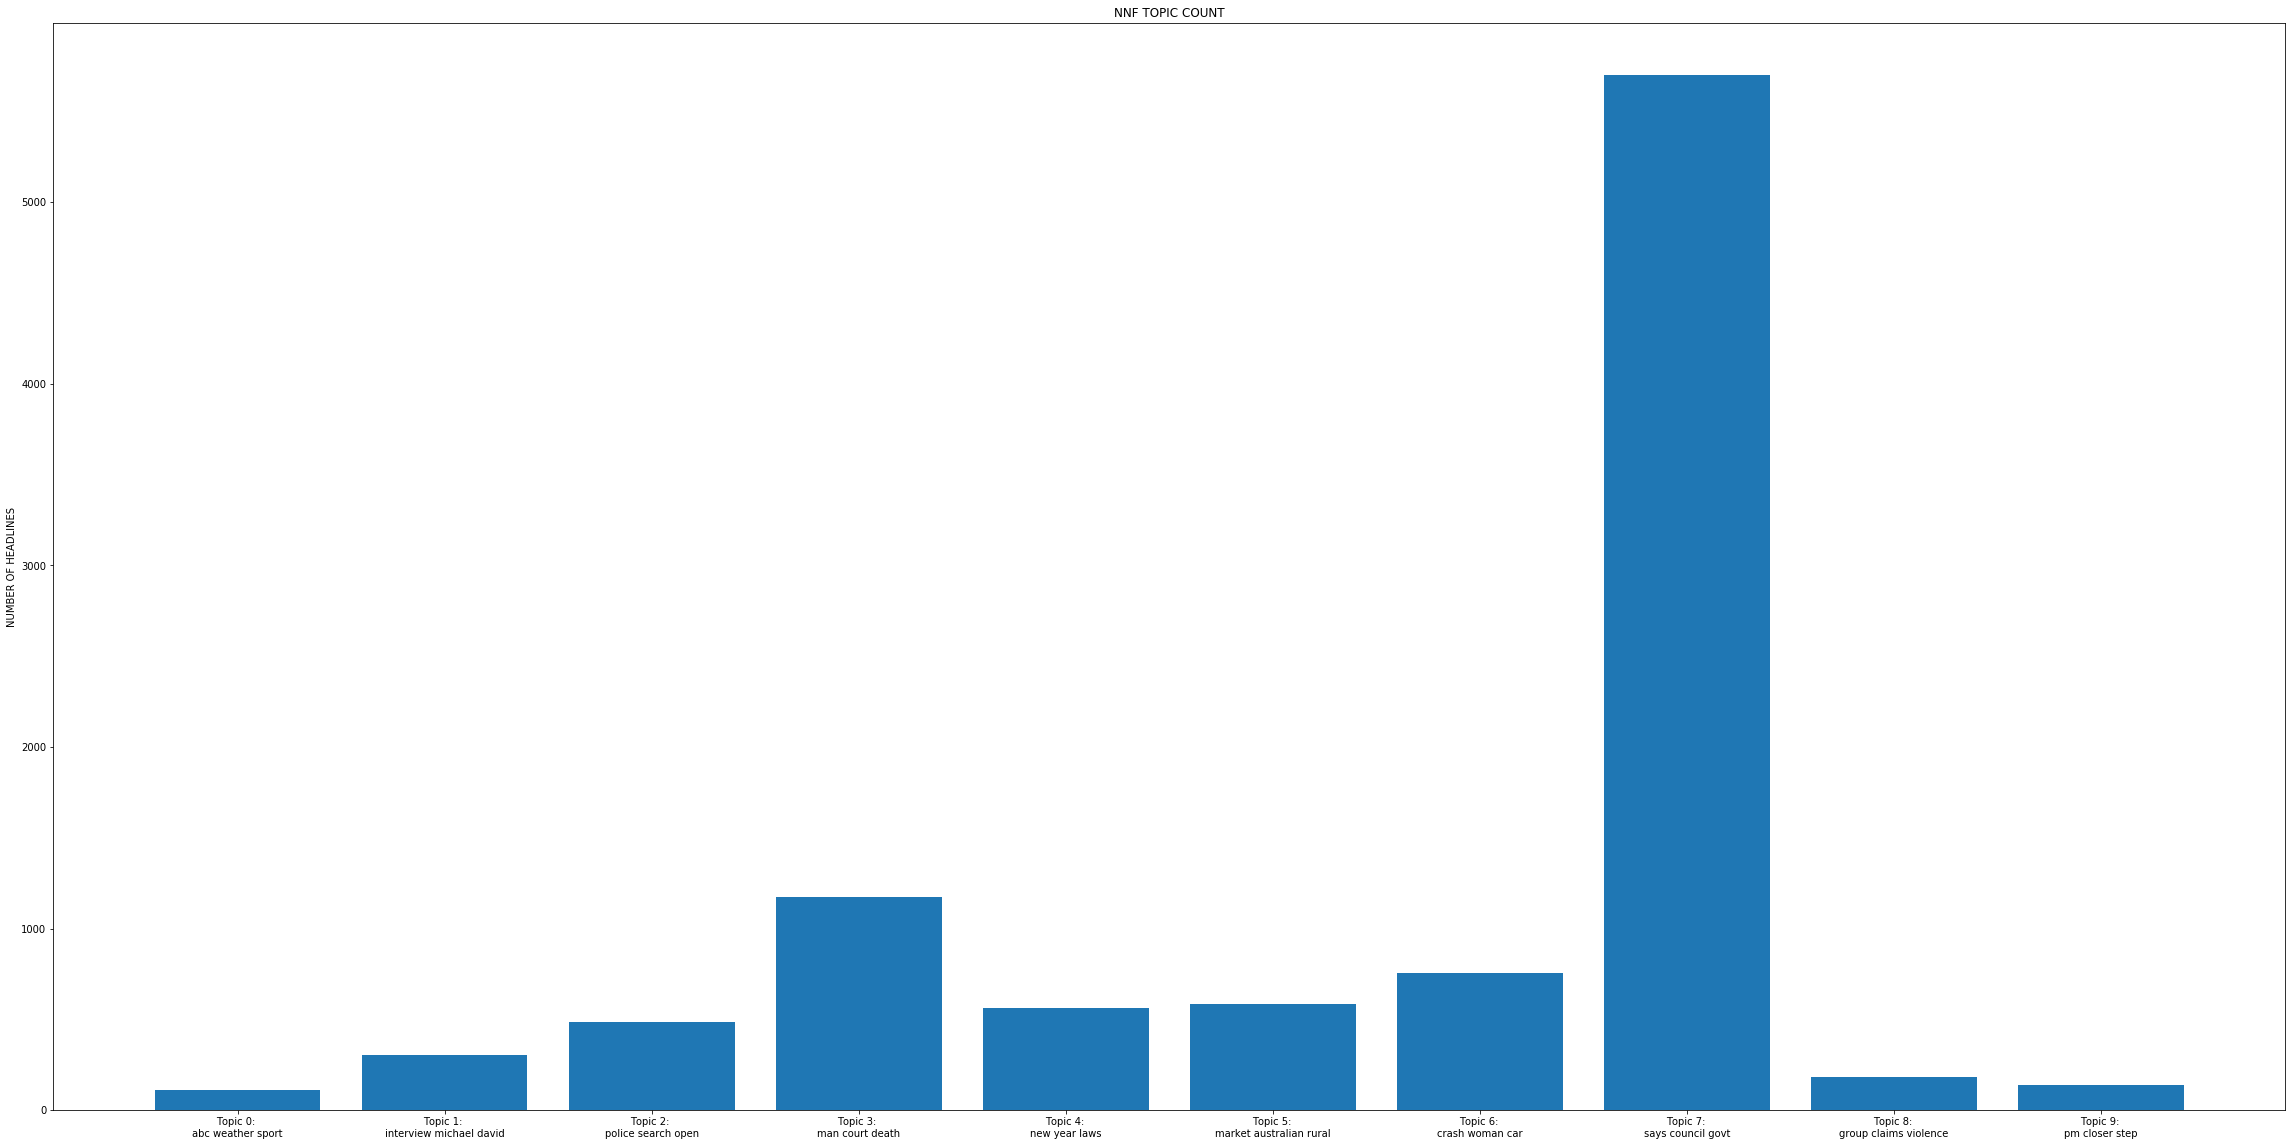

In [37]:
top_3_words = get_top_n_words(3, nnf_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in nnf_categories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(nnf_categories, nnf_counts);
ax.set_xticks(nnf_categories);
ax.set_xticklabels(labels);
ax.set_title('NNF TOPIC COUNT');
ax.set_ylabel('NUMBER OF HEADLINES');

In [38]:
tsne_nnf_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_nnf_vectors = tsne_nnf_model.fit_transform(nnf_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.197s...
[t-SNE] Computed neighbors for 10000 samples in 5.948s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.978798
[t-SNE] KL divergence after 2000 iterations: 1.187423


In [39]:
top_3_words_nnf = get_top_n_words(3, nnf_keys, small_document_term_matrix, small_count_vectorizer)
nnf_mean_topic_vectors = get_mean_topic_vectors(nnf_keys, tsne_nnf_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} NNF TOPICS".format(num_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_nnf_vectors[:,0], y=tsne_nnf_vectors[:,1], color=colormap[nnf_keys])

for t in range(num_topics):
    label = Label(x=nnf_mean_topic_vectors[t][0], y=nnf_mean_topic_vectors[t][1], 
                  text=top_3_words_nnf[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [40]:
big_sample_size = 300000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = newsfile2.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

In [41]:
y_data = []
for i in range(2003,2019+1):
    y_data.append(newsfile2['{}'.format(i)].values)

y_topic_matrices = []
for year in y_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    y_topic_matrices.append(topic_matrix)

y_keys = []
for topic_matrix in y_topic_matrices:
    y_keys.append(get_keys(topic_matrix))
    
y_counts = []
for keys in y_keys:
    categories, counts = keys_to_counts(keys)
    y_counts.append(counts)

y_topic_counts = pd.DataFrame(np.array(y_counts), index=range(2003,2019+1))
y_topic_counts.columns = ['TOPIC {}'.format(i+1) for i in range(num_topics)]

print(y_topic_counts)

      TOPIC 1  TOPIC 2  TOPIC 3  TOPIC 4  TOPIC 5  TOPIC 6  TOPIC 7  TOPIC 8  \
2003     5837     6408     6687     6926     7228     6090     6355     5732   
2004     7580     7516     7127     6958     8062     6680     6344     8160   
2005     7495     6853     7414     7092     7008     7598     8309     7961   
2006     6399     7100     7213     6535     6348     6070     6350     6573   
2007     7482     7689     8675     7149     8524     7803     7429     6999   
2008     7820     8480     8846     8235     7845     7273     7565     7628   
2009     7229     8091     7833     7210     8111     7660     6635     7461   
2010     6292     7961     7824     6702     6976     7751     7799     9015   
2011     8008     7714     8046     7462     7269     8287     6503     7898   
2012     9819     8894     8351     8996     7877     8438     8822     9016   
2013     9669    10961     8501     8963     8657     8961     9021     9121   
2014     7378     9343     8836     7533

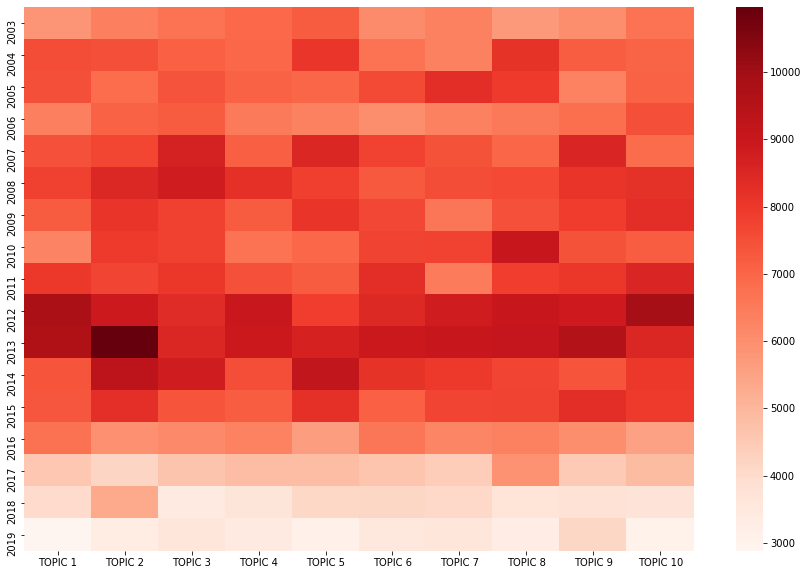

In [42]:
fig, ax = plt.subplots(figsize = (15,10))
sb.heatmap(y_topic_counts, cmap = 'Reds', ax = ax);
plt.show()